In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.ToTensor()

In [3]:
train_sets = torchvision.datasets.MNIST(
    root='./MNIST_DATA',
    train=True,
    transform=transform,
    download=True
)

test_sets = torchvision.datasets.MNIST(
    root='./MNIST_DATA',
    train=False,
    transform=transform,
    download=True
)

In [4]:
batch_size = 256

In [5]:
print(torch.backends.mps.is_available())

True


In [6]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_sets,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_sets,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)   

In [7]:
data_iter = iter(train_loader)
inputs, labels = next(data_iter)
print(inputs.shape, labels.shape)
unique_labels = len(torch.unique(train_sets.targets))
print(f'Labels : {unique_labels}')

torch.Size([256, 1, 28, 28]) torch.Size([256])
Labels : 10


In [8]:
from torch import nn
# 파이토치의 신경망 모듈을 가져온다

# nn.Module 을 상속받아 모델 클래스를 생성
class LinearEntropyModel(nn.Module):
    def __init__(self, input_dim, n_dim, class_count):
        # input_dim : 입력데이터의 크기 (28 * 28 = 784)
        # n_dim : 은닉층의 크기
        # 분류 개수
        
        super().__init__()
        self.layer1=nn.Linear(input_dim, n_dim)
        self.layer2=nn.Linear(n_dim, n_dim)
        self.layer3=nn.Linear(n_dim, class_count)

        # 예제에서는 1이었던 값을 왜 크로스엔트로피를 쓰면서 다중 클래스를 입력하는가
        # 크로스엔트로피는 
        # 왜 3개의 레이어를 구성하는가
        # 다중 퍼셉트론 기반의 회귀 모델
        self.act=nn.ReLU()

    def forward(self, x):
        x=torch.flatten(x, start_dim=1)
        x=self.act(self.layer1(x))
        x=self.act(self.layer2(x))
        x=self.act(self.layer3(x))
        # Linear -> ReLU -> Linear -> ReLU -> Linear -> ReLU
        return x

model=LinearEntropyModel(28*28*1, 1024, unique_labels)

In [9]:
# 모델 구조 요약
# Input:      [B, 1, 28, 28]         # 흑백 이미지 batch
# Flatten:    [B, 784]               # 이미지 한 줄로 펼침
# Layer1:     Linear(784 → 1024)     + ReLU
# Layer2:     Linear(1024 → 1024)    + ReLU
# Layer3:     Linear(1024 → 1)       + ReLU
# Output:     [B, 1]                 # 회귀 또는 이진 분류 용도

In [10]:
from torch.optim import SGD
learning_rate = 0.001
model=model.to('mps')

In [11]:
optimizer=SGD(model.parameters(), lr=learning_rate)

In [12]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [13]:
import numpy as np
from matplotlib import pyplot as plt
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

In [14]:
n_epochs=100
acc_train = []
acc_test = []

for epoch in range(n_epochs):
    total_loss = 0
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('mps'), labels.to('mps')
        preds = model(inputs)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_acc_train = accuracy(model, train_loader)
    epoch_acc_test = accuracy(model, test_loader)
    acc_train.append(epoch_acc_train)
    acc_test.append(epoch_acc_test)
    print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 540.1365885734558
Epoch   1 | Loss: 537.6984062194824
Epoch   2 | Loss: 534.8478269577026
Epoch   3 | Loss: 531.979371547699
Epoch   4 | Loss: 528.9512753486633
Epoch   5 | Loss: 525.6671893596649
Epoch   6 | Loss: 522.068213224411
Epoch   7 | Loss: 518.0932748317719
Epoch   8 | Loss: 513.6365218162537
Epoch   9 | Loss: 508.6188883781433
Epoch  10 | Loss: 503.00709986686707
Epoch  11 | Loss: 496.3230173587799
Epoch  12 | Loss: 488.4365770816803
Epoch  13 | Loss: 479.7528041601181
Epoch  14 | Loss: 470.2463927268982
Epoch  15 | Loss: 459.7963960170746
Epoch  16 | Loss: 448.3988667726517
Epoch  17 | Loss: 436.3078659772873
Epoch  18 | Loss: 423.5391778945923
Epoch  19 | Loss: 410.2961097955704
Epoch  20 | Loss: 396.8932749032974
Epoch  21 | Loss: 383.61385893821716
Epoch  22 | Loss: 370.568355679512
Epoch  23 | Loss: 358.03013134002686
Epoch  24 | Loss: 346.22006690502167
Epoch  25 | Loss: 335.2299087047577
Epoch  26 | Loss: 325.09417259693146
Epoch  27 | Loss: 315.7320

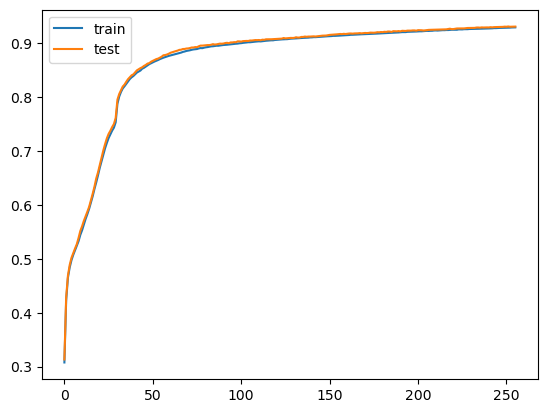

In [100]:
plot_acc(acc_train, acc_test)

학습용 데이터(Train set)와 평가용 데이터(Test set)의 에포크별 정확도 변화 추이가 거의 동일하게 나타난다는 것은, 모델이 학습 과정에서 과적합(overfitting)을 크게 일으키지 않고 학습용 데이터와 평가용 데이터 모두에 대해 유사한 성능을 낸다는 의미입니다. 즉, 모델이 일반화(generalization)를 잘하고 있음을 시사합니다.

심화과제 START

In [8]:
train_set = torchvision.datasets.CIFAR10(
    root='./CIFAR10_DATA',
    train=True,
    transform=transform,
    download=True
)
test_set = torchvision.datasets.CIFAR10(
    root='./CIFAR10_DATA/Test',
    train=False,
    transform=transform,
    download=True
)

100%|████████████████████████████████████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./CIFAR10_DATA/cifar-10-python.tar.gz to ./CIFAR10_DATA


100%|████████████████████████████████████████| 170M/170M [00:13<00:00, 12.7MB/s]


Extracting ./CIFAR10_DATA/Test/cifar-10-python.tar.gz to ./CIFAR10_DATA/Test


In [10]:
n_epochs=50
batch_size=256

In [16]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

In [26]:
data_iter = iter(train_loader)
inputs, labels = next(data_iter)
print(inputs.shape, labels.shape)
print(train_set.classes)
class_count = len(train_set.classes)

torch.Size([256, 3, 32, 32]) torch.Size([256])
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [28]:
from torch import nn

In [40]:
class DepthModel(nn.Module):
    def __init__(self, input_dim, n_dim, class_count):
        super().__init__()
        self.layer1=nn.Linear(input_dim, n_dim)
        self.layer2=nn.Linear(n_dim, n_dim)
        self.layer3=nn.Linear(n_dim, class_count)
        self.act=nn.LeakyReLU()

    def forward(self, x):
        x=torch.flatten(x, start_dim=1)
        x=self.act(self.layer1(x))
        x=self.act(self.layer2(x))
        x=self.act(self.layer3(x))
        return x

model=DepthModel(32*32*3, 1024, class_count)

언제 레이어를 추가해야하는가?
- 성능이 언더피팅 (그래프의 오차가 점점 커지는 경우)

In [48]:
from torch.optim import Adam
adam_learning_rate = 0.001
model=model.to('mps')
adam_optimizer=Adam(model.parameters(), lr=adam_learning_rate)

In [50]:
n_epochs=50
acc_train_cifar = []
acc_test_cifar = []

for epoch in range(n_epochs):
    total_loss = 0
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('mps'), labels.to('mps')
        preds = model(inputs)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(preds, labels)
        loss.backward()
        adam_optimizer.step()

        total_loss += loss.item()

    epoch_acc_train = accuracy(model, train_loader)
    epoch_acc_test = accuracy(model, test_loader)
    acc_train_cifar.append(epoch_acc_train)
    acc_test_cifar.append(epoch_acc_test)
    print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 432.90563464164734
Epoch   1 | Loss: 393.48229026794434
Epoch   2 | Loss: 369.8963255882263
Epoch   3 | Loss: 354.46183454990387
Epoch   4 | Loss: 341.19263327121735
Epoch   5 | Loss: 331.87803840637207
Epoch   6 | Loss: 323.6163351535797
Epoch   7 | Loss: 316.79266238212585
Epoch   8 | Loss: 309.77825140953064
Epoch   9 | Loss: 301.7553449869156
Epoch  10 | Loss: 298.7152910232544
Epoch  11 | Loss: 294.1121093034744
Epoch  12 | Loss: 287.48530209064484
Epoch  13 | Loss: 282.3313058614731
Epoch  14 | Loss: 278.6083867549896
Epoch  15 | Loss: 275.3081661462784
Epoch  16 | Loss: 274.13456881046295
Epoch  17 | Loss: 270.2379837036133
Epoch  18 | Loss: 264.7293645143509
Epoch  19 | Loss: 261.8101465702057
Epoch  20 | Loss: 259.700749874115
Epoch  21 | Loss: 255.5368583202362
Epoch  22 | Loss: 251.77595496177673
Epoch  23 | Loss: 247.7501279115677
Epoch  24 | Loss: 247.39990532398224
Epoch  25 | Loss: 242.43622708320618
Epoch  26 | Loss: 243.29364132881165
Epoch  27 | Loss

In [57]:
n_epochs=50
acc_train_cifar_sgd = []
acc_test_cifar_sgd = []

for epoch in range(n_epochs):
    total_loss = 0
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('mps'), labels.to('mps')
        preds = model(inputs)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_acc_train = accuracy(model, train_loader)
    epoch_acc_test = accuracy(model, test_loader)
    acc_train_cifar_sgd.append(epoch_acc_train)
    acc_test_cifar_sgd.append(epoch_acc_test)
    print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 161.43144017457962


KeyboardInterrupt: 